# CTA Exercise 2: Word Embeddings
## Task
- __(1)__ Find a dataset on which you will train your own word embeddings. This could be downloaded from Kaggle/Github etc. or created by you.
Preprocess the data as needed. If you really do not have an idea or a preference, you can process and use the script from the movie Frozen:
https://imsdb.com/scripts/Frozen-(Disney).html or E.T.: https://imsdb.com/scripts/E.T..html or any other movie script you like. This will make you
practice html tag cleaning J. Another idea could be to use the Wikipedia content you already scraped (including body text).  
- __(2)__ Train your word2vec or GloVe embeddings and visualize your semantic space. Compare your embeddings to a pretrained embedding space of
your choice. For instance, check the top similar words for the most frequent words in your embedding space and in the pre-trained embedding
space. Do the same for some domain specific words etc. Check if it is interesting to compare to WordNet or not.  
- __(3)__ Summarize your impressions including pros and cons after inspecting your own vs. pre-trained embeddings.  
- __(4)__ Submit your Colab notebook by 31st December 2021. If you submit earlier, the instructors will be thankful. If you submit later, you will get zero
points for this exercise.  

Add your shared Colab notebook link here: https://docs.google.com/spreadsheets/d/1wi2MfvjOh5_SOYLE46RnElUuN1GZPwyilbaDGitxLQ/edit?usp=sharing
If you want that only the instructors see your Colab notebook, you can add the following email to the shared list and
select Restricted share: hslu.clt@gmail.com

## Introduction
Fakenews are a challenge for all communities around the globe. Fake news has been used to instrumentalize people for a long time, and not only since US President Trump and the Corona pandemic. For this reason, is there a specific characteristic, with a news article is fake or not fake? 
Will it work? 

The dataset is from Kaggle and can be downloaded via intructions below. 

## Imports

In [5]:
import os,sys
import subprocess

from IPython.display import clear_output

from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
## Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
%matplotlib inline

import seaborn as sns
# Set preferences
sns.set(color_codes=True)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_colwidth', False)

import collections
import regex as re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
from spacy.lang.en import English

import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

clear_output()

In [6]:
gensim.__version__

'3.6.0'

## Getting Data from Kaggle

In [ ]:
#from google.colab import files
#
#uploaded = files.upload()
#
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
#  
## Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets list -s nlp --sort-by hottest

In [ ]:
path_to_data = '/content/drive/MyDrive/NaturalLanguageUnderstanding/homework/data/HomeWork2/'

#subprocess.check_output(f'!kaggle datasets download {input("Which dataset would you like to download? ")}')
#subprocess.check_output(f'!mv $pwd/*.zip {path_to_data}')
#subprocess.check_output(f'!unzip {path_to_data}*.zip -d {path_to_data}')
#subprocess.check_output(f'!rm {path_to_data}*.zip')

## Data Import

In [ ]:
basepath = path_to_data

# Real News df
df_T = pd.read_csv(basepath + "True.csv")
df_T = df_T.assign(FakeNonFake = 0).drop(columns=['subject','date'])

# Fake News df
df_F = pd.read_csv(basepath + "Fake.csv")
df_F = df_F.assign(FakeNonFake = 1).drop(columns=['subject','date'])

# Combination of both dfs
df = pd.concat([df_T,df_F], axis=0)

Let's now check the head and tail of the df

In [ ]:
df.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

The dataframe consists of the columns title, text and description. Additionally I have added an additional column FakeNonFake, which consists of 1 fake news and 0 non-fake news.  
Let's now proceed and the the dimensions, columns and values of the df.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44898 non-null  object
 1   text         44898 non-null  object
 2   FakeNonFake  44898 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


The df contains 44898 articles - all non-null :)  
Let's now check if the fake non-fake news are balanced:

In [ ]:
df['FakeNonFake'].value_counts()

1    23481
0    21417
Name: FakeNonFake, dtype: int64

Let's now calculate the ratio between fake and non-fake news:

In [ ]:
# Fake:1 and NonFake:0 
round(100 - (df['FakeNonFake'].value_counts()[0] / df['FakeNonFake'].value_counts()[1]*100),2)

8.79

The df quite ballanced only approximate 9% difference between Fakenews to Nonfakenews. 

Missing data and empty string check:

In [ ]:
# Any missing data?
df.isna().sum()

title          0
text           0
FakeNonFake    0
dtype: int64

Let's now check as last check, how many text and title are empty string:

In [ ]:
print(df[lambda x: x.text == ''].index)
print(df[lambda x: x.title == ''].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


## Data Cleaning and Preprocessing
First we need to make all values lowercase and add those values to a new column. 

In [ ]:
df = (df
      .applymap(lambda x: x.lower() if type(x) == str else x)
      .applymap(lambda x: (x
                           .replace("n't", " not") # replace n't by not
                           .replace("n’t", " not") # replace n't by not
                           .replace("u.s.","usa") # replace u.s by United States
                           .replace("[video]","") # replace video attachment information
                           ) if type(x) == str else x)
)
df.head(1)

title  \
0  as usa budget fight looms, republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
df = df.drop(columns=['text'])

### Feature Engineering

Several features are going to be added in order to enrich the data. Generic speaking, all punctuations will be removed.  
These features are going to be added:  
* tokens: Tokens after passing the string to spacy. 
* num_of_tokens:  number of tokens per column element
* tokens_wo_stopwords: Tokens (w/o stoppwords) after passing the string to spacy. 
* num_tokens_wo_stopwords: number of tokens (w/o stoppwords) per column element

In [ ]:
## Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])
stop = stopwords.words('english')
# get the stopwords for the english language
stop += ['nt', ' ' ,'#', "’s","'s",'us','video'] # Additionally # and 's have been added

# Function of tokenize text -> list
def tokenize(text):
  return [t.text for t in nlp(text) if not t.is_punct]  # removes punctiuation from each token

# Apply tokenization to titles
df['tokens'] = df['title'].apply(tokenize)
# Generate a new column with the number of tokens in title
df['num_of_tokens'] = [len(title) for title in df['tokens']]
# Apply tokenization to titles without stopwords
df['tokens_wo_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop])
# Generate a new column with the number of tokens in title not considering stopwords
df['num_of_tokens_wo_stopwords'] = [len(title) for title in df['tokens_wo_stopwords']]

df.sample(5)

,title,FakeNonFake,tokens,num_of_tokens,tokens_wo_stopwords,num_of_tokens_wo_stopwords
16944,"new zealand election result stokes housing, migration fears",0,"[new, zealand, election, result, stokes, housing, migration, fears]",8,"[new, zealand, election, result, stokes, housing, migration, fears]",8
911,house tax panel chair: corporate tax cut may take 'several steps',0,"[house, tax, panel, chair, corporate, tax, cut, may, take, several, steps]",11,"[house, tax, panel, chair, corporate, tax, cut, may, take, several, steps]",11
19602,beggin’ megyn kelly’s new book ripped to shreads in amazon reviews…karma!,1,"[beggin, megyn, kelly, ’s, new, book, ripped, to, shreads, in, amazon, reviews, karma]",13,"[beggin, megyn, kelly, new, book, ripped, shreads, amazon, reviews, karma]",10
5375,rnc blasts white supremacist’s tweet on big screen during trump’s speech (images),1,"[ , rnc, blasts, white, supremacist, ’s, tweet, on, big, screen, during, trump, ’s, speech, images]",15,"[rnc, blasts, white, supremacist, tweet, big, screen, trump, speech, images]",10
14746,"german spy chief sees russia as danger, cites military advances",0,"[german, spy, chief, sees, russia, as, danger, cites, military, advances]",10,"[german, spy, chief, sees, russia, danger, cites, military, advances]",9


Let's now check the 10 most common words of the fake news:

In [ ]:
tokens = []
for row in df[df.FakeNonFake == 1]['tokens_wo_stopwords']:
  for element in row:
    tokens.append(element)

occurences = collections.Counter(tokens)
sorted(occurences.items(), key=lambda item: item[1], reverse=True)[0:10]

[('trump', 9311),
 ('obama', 2576),
 ('hillary', 2316),
 ('watch', 1937),
 ('clinton', 1138),
 ('president', 1137),
 ('new', 905),
 ('breaking', 896),
 ('black', 892),
 ('news', 883)]

Let's now check the 10 most common words of the non-fake news:

In [ ]:
tokens = []
for row in df[df.FakeNonFake == 0]['tokens_wo_stopwords']:
  for element in row:
    tokens.append(element)

occurences = collections.Counter(tokens)
sorted(occurences.items(), key=lambda item: item[1], reverse=True)[0:10]

[('trump', 5560),
 ('usa', 4177),
 ('says', 2981),
 ('house', 1449),
 ('russia', 977),
 ('north', 926),
 ('korea', 888),
 ('new', 875),
 ('white', 813),
 ('china', 782)]

Now the dataset is good to go. Let's now create two subsets of the dataset:
- df_fake: For all fake news articles
- df_real: For all real news articles  

In [ ]:
df_fake = df[df.FakeNonFake == 1].drop(columns=['FakeNonFake'])
df_real = df[df.FakeNonFake == 0].drop(columns=['FakeNonFake'])

## Fit the Word2Vec Model

This is essentially a simple neural network where the inputs are target words and the outputs are context words (or vice versa, depending on the word2vec variant). The word embeddings are the activation formed by the hidden layer of the neural network when that word is presented as an input. The following are the main parameters of the model:
* `sentences` - a list of the tokenized texts we will use
* `size` - the dimensionality of the word embedding (100 means each word is mapped to a 100 element vector). 300 seems to be the most popular choice for embeddings trained on massive datasets.
* `window` - the distance in number of words considered "in context" for a given target word. Larger windows (>5) result in embeddings that are more reflective of word meaning. Smaller windows result in embeddings that are more reflective of word syntax (how it is used in a sentence). For example, "good" and "bad" have opposite meaning but similar syntax, i.e. you can replace one with the other in most sentences without violating any grammatical rules.
* `sg` – training algorithm: 1 for skip-gram; otherwise CBOW.





### Own model

In [ ]:
sum(df['num_of_tokens_wo_stopwords'])/len(df['num_of_tokens_wo_stopwords'])

9.380217381620563

In [ ]:
## Set values for various parameters
feature_size = 100    ## Word vector dimensionality
window_context = 9    ## Maximum distance between the current and predicted word within a sentence => as checked above
min_word_count = 1    ## Minimum word count (Ignores all words with total frequency lower than this)
sg = 0    ## 0 = CBOW (context), 1 = skip-gram (current word)

## model with all titles
w2vmodel = Word2Vec(sentences=df['tokens_wo_stopwords'], size=feature_size, window=window_context, min_count=min_word_count, sg=sg)

## model with only real_news
w2vmodel_real = Word2Vec(sentences=df_real['tokens_wo_stopwords'], size=feature_size, window=window_context, min_count=min_word_count, sg=sg)

## model with only sarcastic headlines from TheOnion
w2vmodel_fake = Word2Vec(sentences=df_fake['tokens_wo_stopwords'], size=feature_size, window=window_context, min_count=min_word_count, sg=sg)

In [ ]:
print('The size of all-news model is:',w2vmodel.vector_size)
print('The size of real-news model is:',w2vmodel_real.vector_size)
print('The size of fake-news model is:',w2vmodel_fake.vector_size)

The size of all-news model is: 100
The size of real-news model is: 100
The size of fake-news model is: 100


### Comparison: All News, Fake News and Real News
Since `trump` is the top scorer in both categories, lets check which words are similar in the overall, fake, and non-fake news articles.

In [ ]:
## compare model outputs of overall, fake and non-fake w2vmodel
def model_comparisons(word, num_of_similar_words):
  print('All headlines: \n', str(w2vmodel.wv.most_similar(positive = word, topn=num_of_similar_words)), '\n')
  print('\nNon-fake headlines: \n', str(w2vmodel_real.wv.most_similar(positive = word, topn=num_of_similar_words)), '\n')
  print('\nfake headlines: \n', str(w2vmodel_fake.wv.most_similar(positive = word, topn=num_of_similar_words)))

model_comparisons('trump', 3)

All headlines: 
 [('dodger', 0.7274099588394165), ('shakespearean', 0.7247329950332642), ('pga', 0.7243388295173645)] 


Non-fake headlines: 
 [('vietnam', 0.9985692501068115), ('heads', 0.9983879327774048), ('choice', 0.9982717633247375)] 


fake headlines: 
 [('jr', 0.9886692762374878), ('vice', 0.9883031249046326), ('twitter', 0.9880771636962891)]


Let's plot the word by each times of occurance in the corpus. First real-news without stopwords

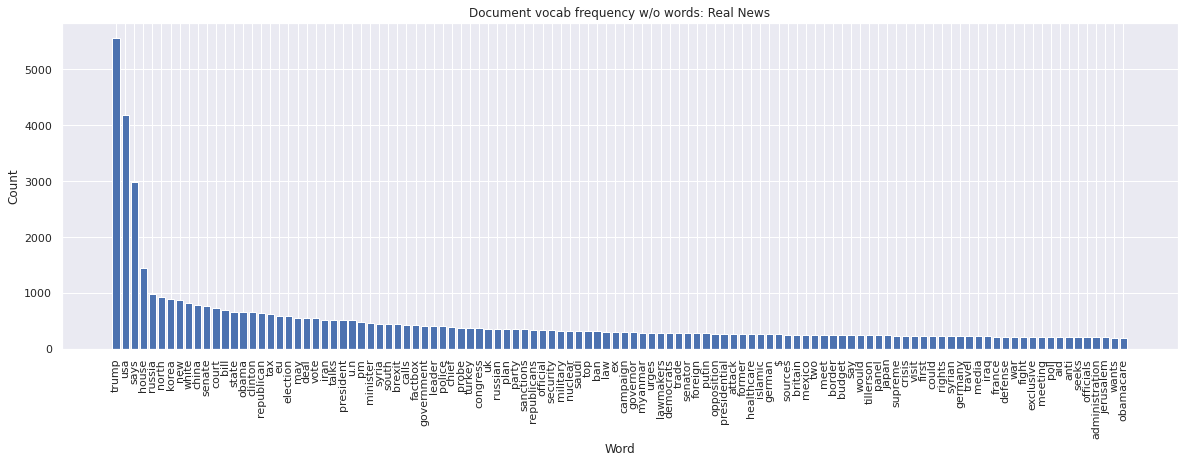

In [ ]:
# Most frequent words in the w2v model w/o words
w2c = dict()
for item in w2vmodel_real.wv.vocab:
  w2c[item] = w2vmodel_real.wv.vocab[item].count

w2c_sort = dict(sorted(w2c.items(), key=lambda x: x[1], reverse=True))

word_count = dict((k, v) for k, v in w2c_sort.items() if v >= 200)

plt.figure(figsize=(20, 6))
plt.bar(word_count.keys(), word_count.values())
plt.title('Document vocab frequency w/o words: Real News')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90)
plt.show()

First fake-news without stopwords

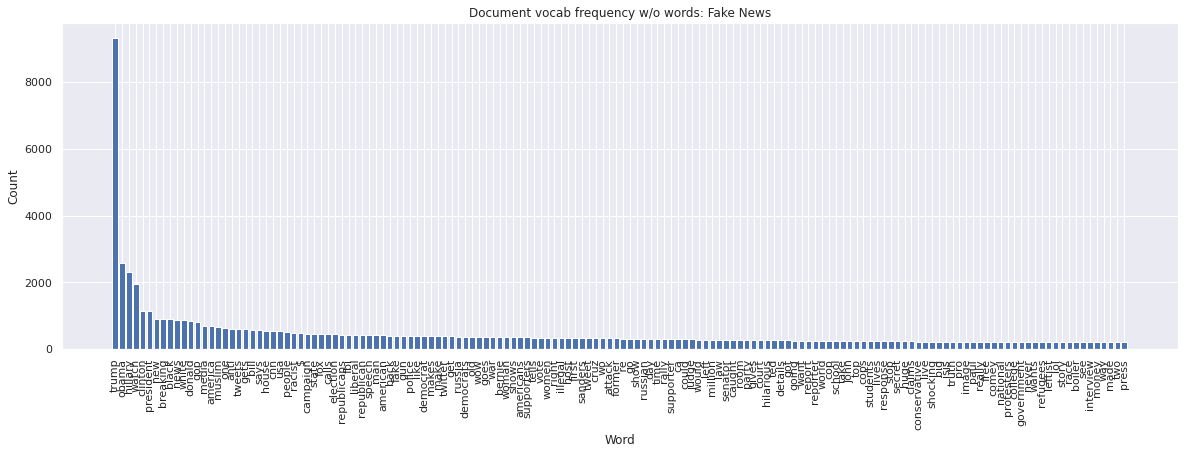

In [ ]:
# Most frequent words in the w2v model w/o words
w2c = dict()
for item in w2vmodel_fake.wv.vocab:
  w2c[item] = w2vmodel_fake.wv.vocab[item].count

w2c_sort = dict(sorted(w2c.items(), key=lambda x: x[1], reverse=True))

word_count = dict((k, v) for k, v in w2c_sort.items() if v >= 200)

plt.figure(figsize=(20, 6))
plt.bar(word_count.keys(), word_count.values())
plt.title('Document vocab frequency w/o words: Fake News')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90)
plt.show()

### Visualization

#### Visualisation Semantic Space: All news

In [ ]:
# get the word forms of voculary sample
words = w2vmodel.wv.index2word[200:350]      
# Create a list of only words present in all subsets
words = [word for word in words if word in w2vmodel_real and word in w2vmodel_fake]

# Create set embedings of words for later transformation
wvs_1 = w2vmodel_real.wv[words]
wvs_2 = w2vmodel_fake.wv[words] 
wvs_3 = w2vmodel.wv[words] 

# Mapping words into 2D space      
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
labels = words

# Apply transformation
T_1 = tsne.fit_transform(wvs_1) # Real News
T_2 = tsne.fit_transform(wvs_2) # Fake News
T_3 = tsne.fit_transform(wvs_3) # All News

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


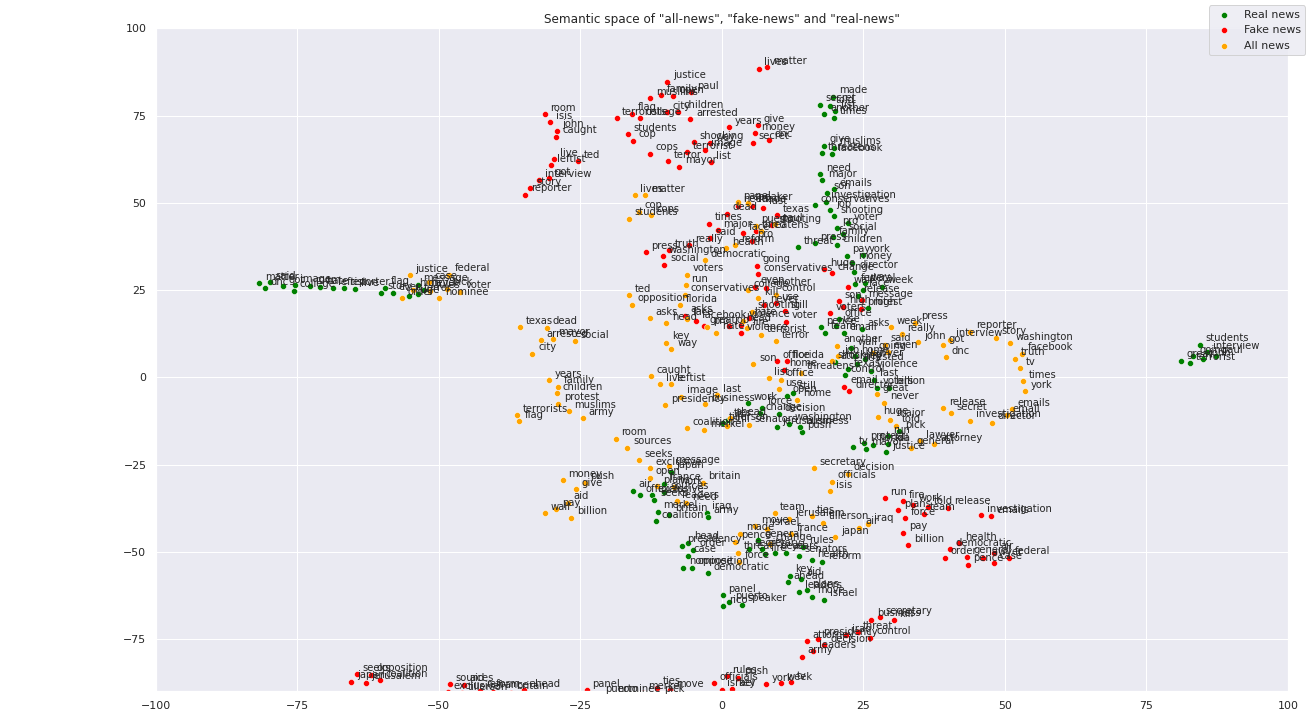

In [ ]:
# Real news plot
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot( x= T_1[:, 0], y= T_1[:, 1], color = 'green')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_1[:, 0], T_1[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')


sns.scatterplot(x = T_2[:, 0], y= T_2[:, 1], color = 'red')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_2[:, 0], T_2[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')
    

sns.scatterplot(x = T_3[:, 0], y= T_3[:, 1], color = 'orange')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_3[:, 0], T_3[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')
plt.title('Semantic space of "all-news", "fake-news" and "real-news"')
fig.legend(labels=['Real news', 'Fake news','All news'], loc='best')
fig.tight_layout()

The upper graph shows the semantic space of the fake news, true news and of all news.  

As it seems, purely graphically speaking, it can be assumed that the tokens tends fall into clusters.  
However, the individual points are not in the same cluster - e.g. Jerusalem is found in the upper middle of the graph in the fake news, while Jerusalem is rather a little bit further down in the real news. 

In summary, it can already be said that the individual words do not play significant role, but the combination of the individual words.  


#### Visualisation Semantic Space: Fake News

Let's see if we can find cluster as well in either in the real-news of fake-news models. Let's start with the fake-news:

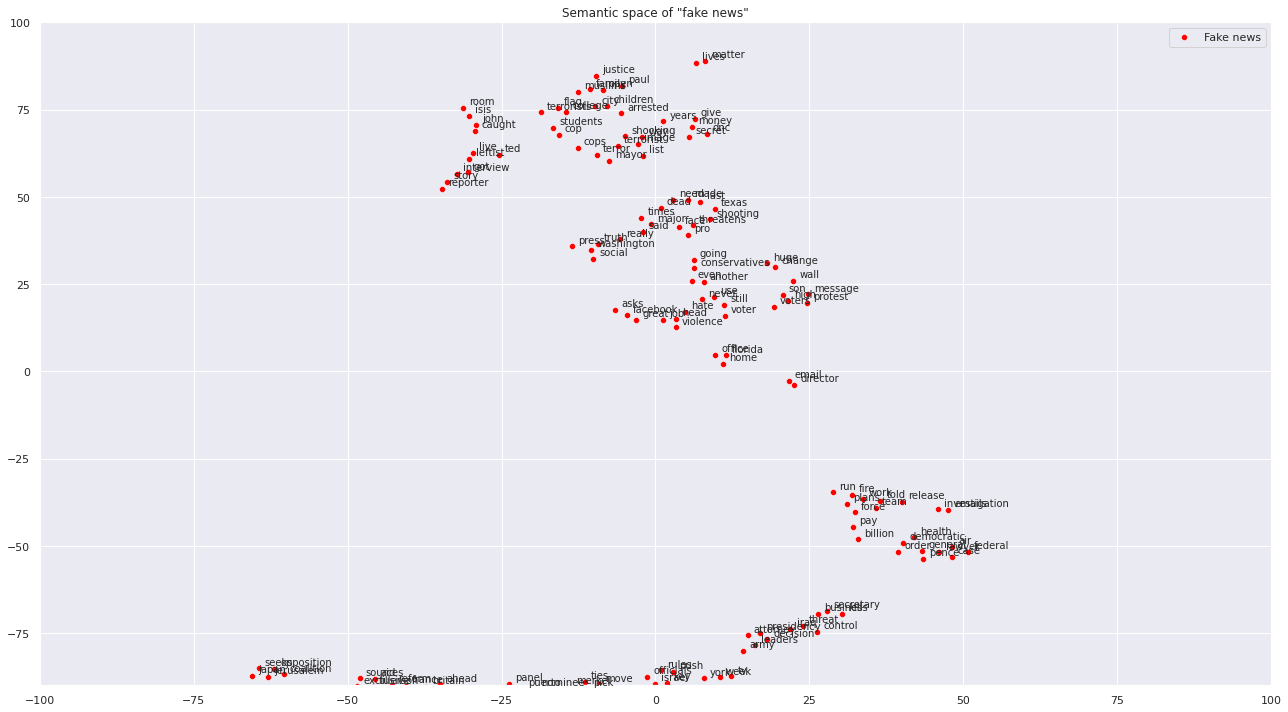

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot(x = T_2[:, 0], y= T_2[:, 1], color = 'red')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_2[:, 0], T_2[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')
plt.title('Semantic space of "fake news"')
plt.legend(labels=['Fake news'], loc='best')
plt.tight_layout()

Interesting, that the fake-news model delivers more clear boundaries between the clusters. The most clear cluster can be found the lower right portion of the graph, containing the following key-words:

- `nfl`, `hollywood`, `sexual`, `politicaly`, `childern`, `justice`, `ep`, `muslims`

#### Visualisation Semantic Space: Real News

Let's have closer look at the word-embeddings of the real news:

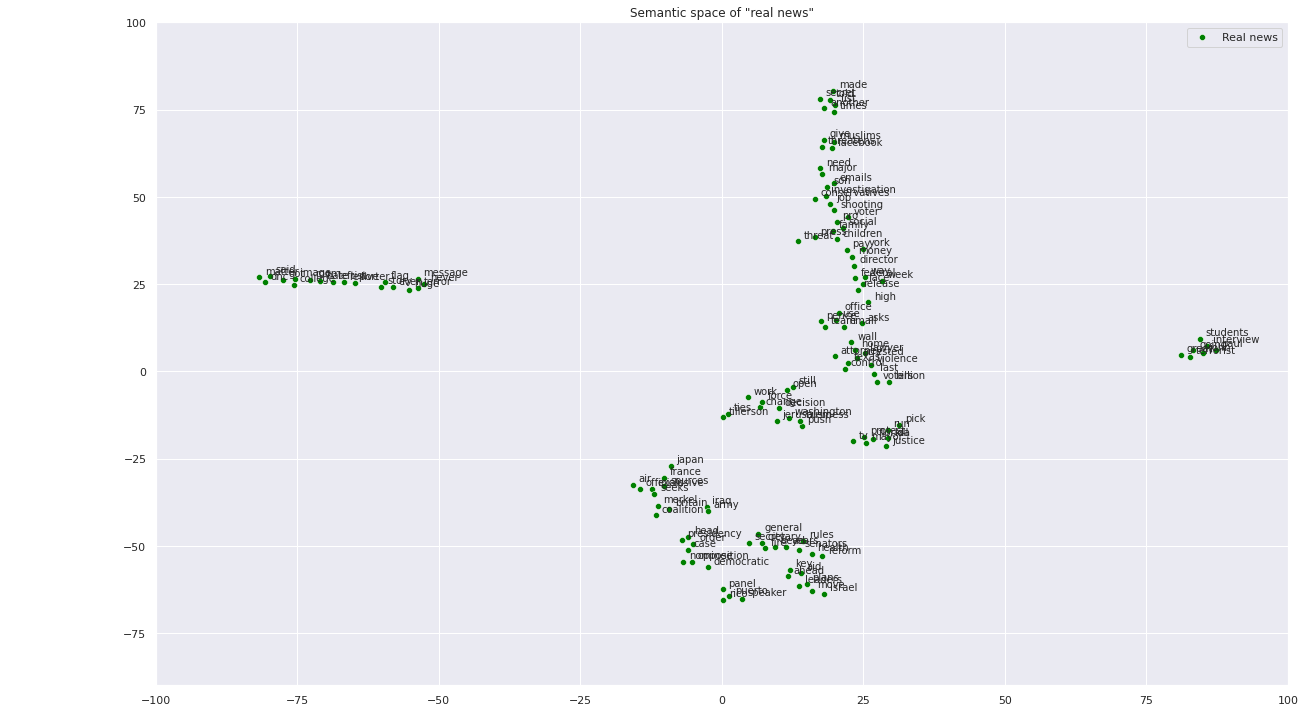

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot( x= T_1[:, 0], y= T_1[:, 1], color = 'green')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_1[:, 0], T_1[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')
plt.title('Semantic space of "real news"')
plt.legend(labels=['Real news'], loc='best')
plt.tight_layout()

The real news delivers different semantic cluster, based on the corpus of the real news. I see several semantic spaces, which seems to show the semantic relation of the given corpus.

__Summarizing Semantic Visualisation__:  
When comparing the cluster of the overall model with the fake-news and non-fake-news it clearly can be point out, that semantic space is better divideable into cluster of similar words. The __fake-news__ visualizazion shows a little bit let clear boundaries compared to the __real-news__ visualization. It is clearly visible, that the real-news seems to be focused on three semantic subspaces and maybe four.  
All this information would have to investigated and veryfied using clustering algorithm to check if the cluster hypothesis can be holded or not.  

Let's now investigate the most common word for both categories: `trump`

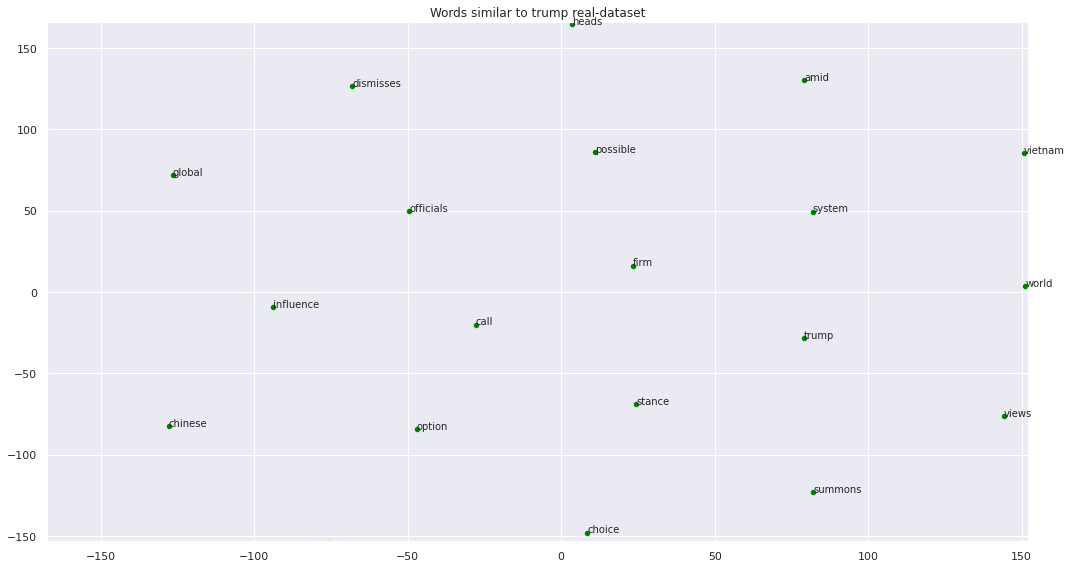

In [ ]:
# Select topn similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size, topn, title, type_, color):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=topn)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    clear_output()
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    sns.scatterplot( x = x_coords, y = y_coords, color=color)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+1, x_coords.max()+1)
    plt.ylim(y_coords.min()+1, y_coords.max()+1)
    plt.title(f'Words similar to {word} {type_}-dataset')
    plt.tight_layout()
    plt.show()

word = 'trump'
display_closestwords_tsnescatterplot(w2vmodel_real, word , w2vmodel_real.vector_size, 20, title = word, type_= 'real', color='green')

The two closest words to `trump` in the real news dataset are: tourism and force. 

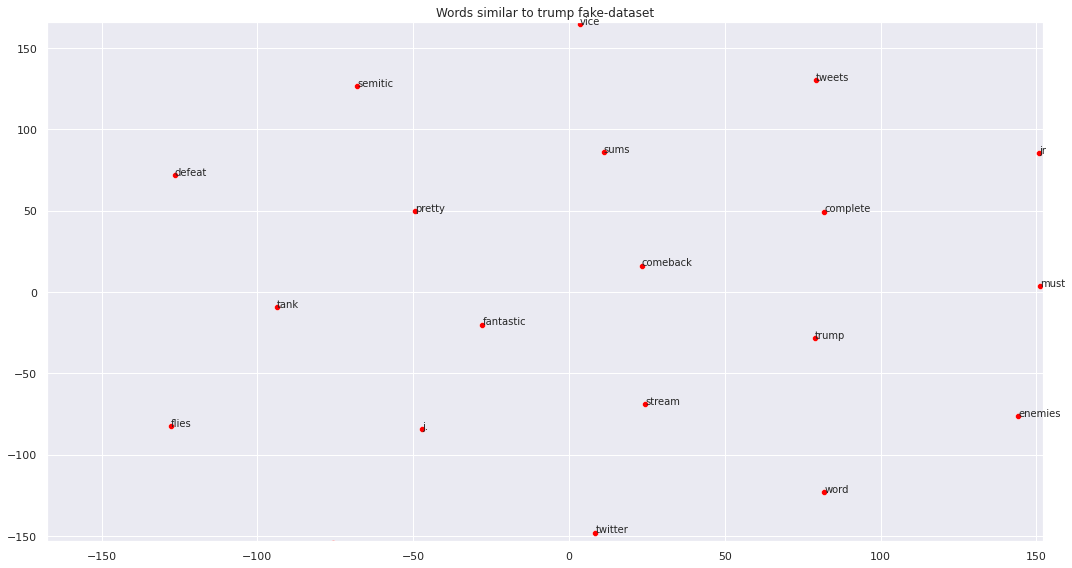

In [ ]:
display_closestwords_tsnescatterplot(w2vmodel_fake, word , w2vmodel_fake.vector_size, 20, title = word, type_='fake',color='red')

The two closest words to `trump` in the fake news dataset are: credibility and saturday. 

## Comparison to pretrained embeddings  

In this last section, I want to go through the comparison of my own Word2Vec model to petrained model. 

__Lecturer Notes:__  

> Pretrained word embeddings are vector representation of words trained on a larger dataset. With pretrained embeddings, you will be using the weights and vocabulary from the end result of the training process done by someone else! 

>Now check out pretrained word embeddings. This time, not Word2Vec, but GloVe.
The GloVe embeddings used below was trained on an English Wikipedia dump and English Gigaword 5th Edition dataset. Its dimensionality is 100 and has 6B tokens. The original source of the embeddings can be found here: https://nlp.stanford.edu/projects/glove/


### GloVe Model

In [ ]:
import gensim.downloader as api

glove_vectors = api.load('glove-wiki-gigaword-100')
glove_vectors.vector_size

100

In [ ]:
glove_vectors.most_similar('trump')

[('nows', 0.5873242616653442),
 ('hilton', 0.5507662892341614),
 ('casino', 0.5180235505104065),
 ('ivanka', 0.5056729316711426),
 ('mih', 0.47354456782341003),
 ('mahal', 0.47065550088882446),
 ('taj', 0.4643707275390625),
 ('condo', 0.46357983350753784),
 ('vegas', 0.4624684453010559),
 ('developer', 0.46145099401474)]

In [ ]:
def comparison(model, search_values):
  # Similar Words
  similar_words_word2vec = {
      search_term:
      [item[0] for item in model.wv.most_similar([search_term], topn=5)]
      for search_term in search_values
  }

  similar_words_glove = {
      search_term:
      [item[0] for item in glove_vectors.most_similar([search_term], topn=5)]
      for search_term in search_values
  }
  return [similar_words_word2vec,similar_words_glove]

In [ ]:
words_real = w2vmodel_real.wv.index2word[0:10]               ## get the word forms of voculary sample
words_fake = w2vmodel_fake.wv.index2word[0:10]               ## get the word forms of voculary sample
values = comparison(w2vmodel_real, words_real)  
print('word2vec\n',values[0])
print('GloVe\n',values[1])

word2vec
 {'trump': ['vietnam', 'heads', 'choice', 'stance', 'option'], 'usa': ['missiles', 'weapons', 'kremlin', 'range', 'threats'], 'says': ['visit', 'trade', 'agree', 'discuss', 'japan'], 'house': ['ryan', 'powder', 'rico', 'retweets', 'mulvaney'], 'russia': ['tillerson', 'u.n', 'discuss', 'lavrov', 'visit'], 'north': ['denuclearization', 'destabilizing', 'south', 'moon', 'hydrogen'], 'korea': ['hydrogen', 'moon', 'denuclearization', 'sanctions', 'china'], 'new': ['could', 'eyes', 'european', 'venezuela', 'go'], 'white': ['speaker', 'ryan', 'panel', '-white', 'bill'], 'china': ['missile', 'diplomacy', 'moon', 'korean', 'mediate']}
GloVe
 {'trump': ['nows', 'hilton', 'casino', 'ivanka', 'mih'], 'usa': ['canada', 'america', 'u.s.a.', 'united', 'states'], 'says': ['believes', 'said', 'does', 'wants', 'thinks'], 'house': ['office', 'senate', 'room', 'houses', 'capitol'], 'russia': ['ukraine', 'russian', 'moscow', 'belarus', 'bulgaria'], 'north': ['south', 'west', 'east', 'northeast', '

The Glove model seems to be recognizing the word `trump` as verb/adjective and not as a person. While my word2vec model has the relevant context as a person and it sees other words as similar. 
For the verbs the performance is in the other hand better, as the corpus seems to be more ballanced towards grammatics and for example in `says`it tries to find similar words to the verb, while the word2vec model delivers quite specific recommendations.

#### Visualisation Semantic Space

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


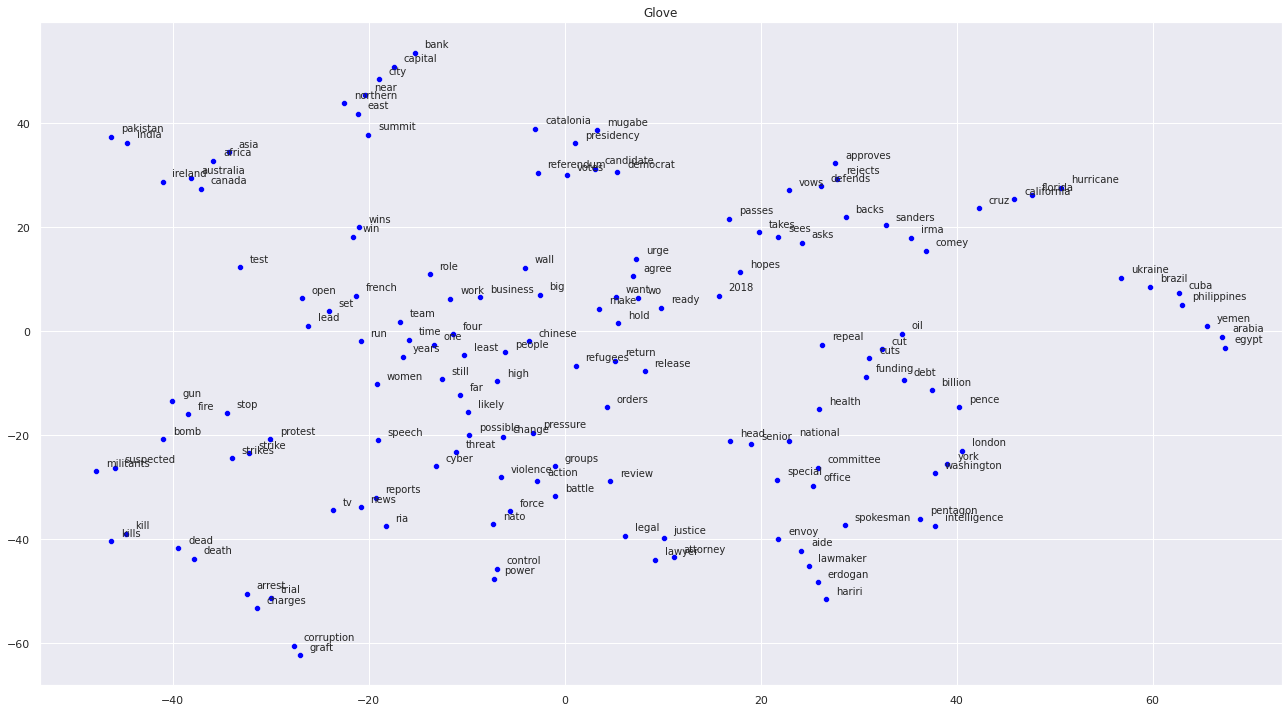

In [ ]:
words = w2vmodel_real.wv.index2word[200:350]      ## get the word forms of voculary sample
try:
  wvs = glove_vectors.wv[words]              ## get embeddings of word forms
except KeyError as e:
  print(e)

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
sns.scatterplot(x = T[:, 0], y = T[:, 1], color='blue')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.title('Glove')
plt.tight_layout()

### Fasttext

In [ ]:
## fastText vectors -> will help you with OOV
ft_vectors = api.load('fasttext-wiki-news-subwords-300')
ft_vectors.vector_size

300

In [ ]:
ft_vectors.most_similar('trump')

[('trumps', 0.8457010388374329),
 ('trumping', 0.7876768112182617),
 ('non-trump', 0.7490019798278809),
 ('trumped', 0.7124733328819275),
 ('notrump', 0.6544545888900757),
 ('supercede', 0.6326020956039429),
 ('overrule', 0.6288058757781982),
 ('no-trump', 0.6278952360153198),
 ('override', 0.6258442401885986),
 ('supersede', 0.6115215420722961)]

In [ ]:
words_real = w2vmodel_real.wv.index2word[0:10]               ## get the word forms of voculary sample
words_fake = w2vmodel_fake.wv.index2word[0:10]               ## get the word forms of voculary sample
values = comparison(w2vmodel_real, words_real)  
print('word2vec\n',values[0])
print('GloVe\n',values[1])

word2vec
 {'trump': ['vietnam', 'heads', 'choice', 'stance', 'option'], 'usa': ['missiles', 'weapons', 'kremlin', 'range', 'threats'], 'says': ['visit', 'trade', 'agree', 'discuss', 'japan'], 'house': ['ryan', 'powder', 'rico', 'retweets', 'mulvaney'], 'russia': ['tillerson', 'u.n', 'discuss', 'lavrov', 'visit'], 'north': ['denuclearization', 'destabilizing', 'south', 'moon', 'hydrogen'], 'korea': ['hydrogen', 'moon', 'denuclearization', 'sanctions', 'china'], 'new': ['could', 'eyes', 'european', 'venezuela', 'go'], 'white': ['speaker', 'ryan', 'panel', '-white', 'bill'], 'china': ['missile', 'diplomacy', 'moon', 'korean', 'mediate']}
GloVe
 {'trump': ['nows', 'hilton', 'casino', 'ivanka', 'mih'], 'usa': ['canada', 'america', 'u.s.a.', 'united', 'states'], 'says': ['believes', 'said', 'does', 'wants', 'thinks'], 'house': ['office', 'senate', 'room', 'houses', 'capitol'], 'russia': ['ukraine', 'russian', 'moscow', 'belarus', 'bulgaria'], 'north': ['south', 'west', 'east', 'northeast', '

The Fasttext model seems to be recognizing the word `trump` as verb/adjective and not as a person. While my word2vec model has the relevant context as a person and it sees other words as similar. 
For the verbs the performance is in the other hand better, as the corpus seems to be more ballanced towards grammatics and for example in `says`it tries to find similar words to the verb, while the word2vec model delivers quite specific recommendations.

#### Visualisation Semantic Space

"word 'irma' not in vocabulary"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


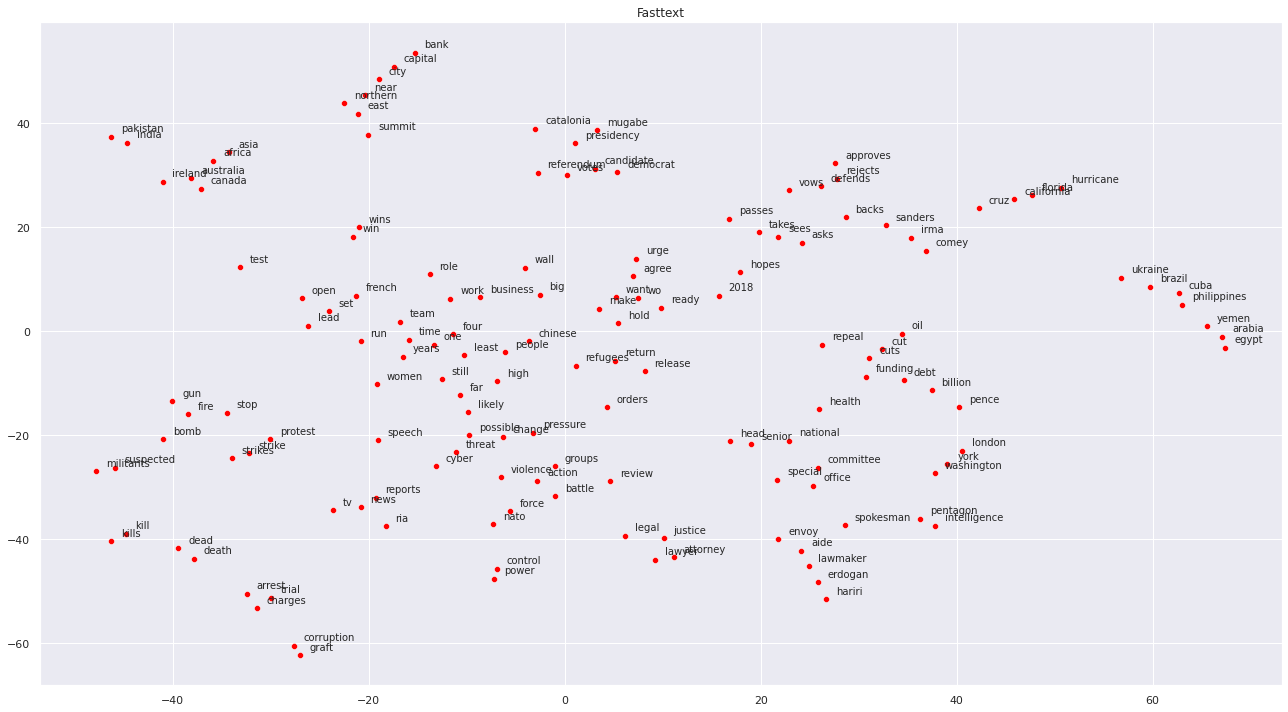

In [ ]:
words = w2vmodel_real.wv.index2word[200:350]      ## get the word forms of voculary sample
try:
  wvs = ft_vectors.wv[words]                     ## get embeddings of word forms
except KeyError as e:
  print(e)


tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
sns.scatterplot(x = T[:, 0], y = T[:, 1], color='red')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.title('Fasttext')
plt.tight_layout()

### Google News Model

In [ ]:
google_news = api.load('word2vec-google-news-300')
google_news.vector_size

300

In [ ]:
google_news.most_similar('trump')

[('trumps', 0.7198435068130493),
 ('trumping', 0.580585241317749),
 ('supersede', 0.5600422620773315),
 ('trumped', 0.5497318506240845),
 ('supercede', 0.5309919118881226),
 ('prevail', 0.487763375043869),
 ('outweigh', 0.4785327613353729),
 ('trample', 0.47142529487609863),
 ('overshadow', 0.47011539340019226),
 ('dictate', 0.46754562854766846)]

In [ ]:
words_real = w2vmodel_real.wv.index2word[1:10]               ## get the word forms of voculary sample
words_fake = w2vmodel_fake.wv.index2word[1:10]               ## get the word forms of voculary sample
values = comparison(w2vmodel_real, words_real)  
print('word2vec\n',values[0])
print('GloVe\n',values[1])

word2vec
 {'usa': ['missiles', 'weapons', 'kremlin', 'range', 'threats'], 'says': ['visit', 'trade', 'agree', 'discuss', 'japan'], 'house': ['ryan', 'powder', 'rico', 'retweets', 'mulvaney'], 'russia': ['tillerson', 'u.n', 'discuss', 'lavrov', 'visit'], 'north': ['denuclearization', 'destabilizing', 'south', 'moon', 'hydrogen'], 'korea': ['hydrogen', 'moon', 'denuclearization', 'sanctions', 'china'], 'new': ['could', 'eyes', 'european', 'venezuela', 'go'], 'white': ['speaker', 'ryan', 'panel', '-white', 'bill'], 'china': ['missile', 'diplomacy', 'moon', 'korean', 'mediate']}
GloVe
 {'usa': ['canada', 'america', 'u.s.a.', 'united', 'states'], 'says': ['believes', 'said', 'does', 'wants', 'thinks'], 'house': ['office', 'senate', 'room', 'houses', 'capitol'], 'russia': ['ukraine', 'russian', 'moscow', 'belarus', 'bulgaria'], 'north': ['south', 'west', 'east', 'northeast', 'southeast'], 'korea': ['pyongyang', 'korean', 'dprk', 'seoul', 'japan'], 'new': ['york', 'the', 'as', 'for', 'this'],

The Google model seems to be recognizing the word `trump` as verb/adjective and not as a person. While my word2vec model has the relevant context as a person and it sees other words as similar. 
For the verbs the performance is in the other hand better, as the corpus seems to be more ballanced towards grammatics and for example in `says`it tries to find similar words to the verb, while the word2vec model delivers quite specific recommendations.

#### Visualisation Semantic Space

"word 'catalonia' not in vocabulary"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


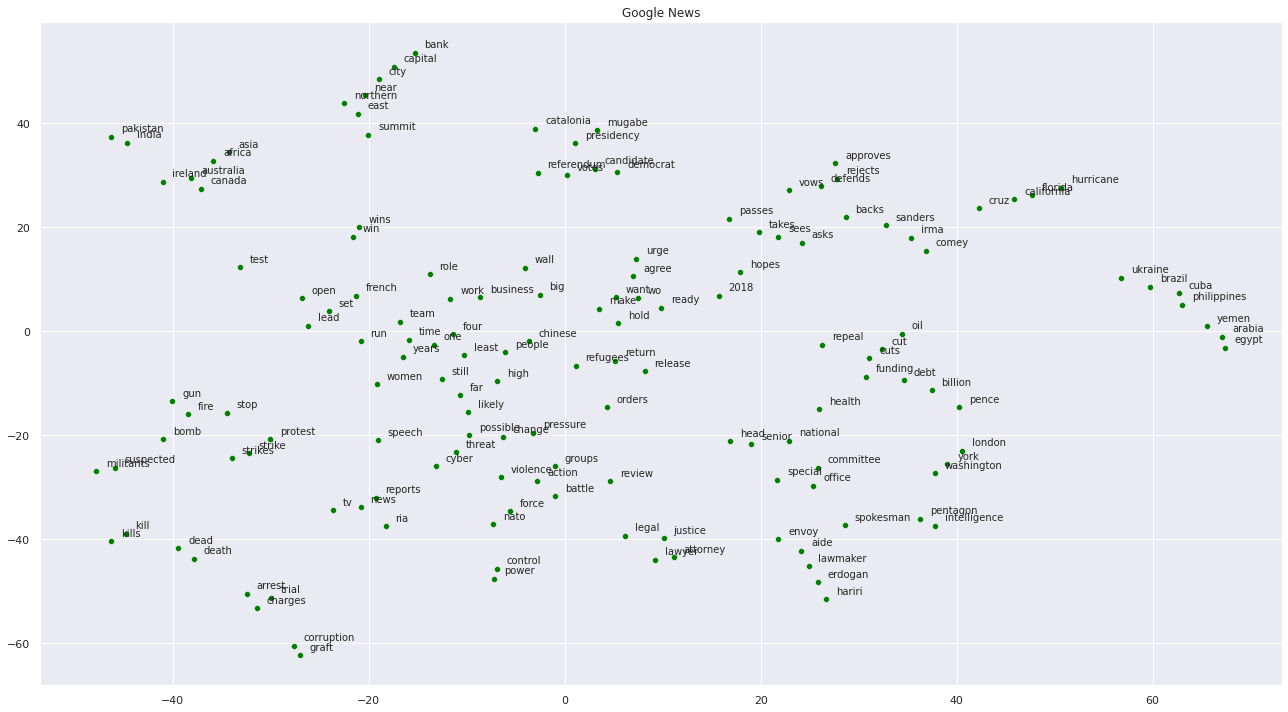

In [ ]:
words = w2vmodel_real.wv.index2word[200:350]      ## get the word forms of voculary sample
try:
  wvs = google_news.wv[words]                     ## get embeddings of word forms
except KeyError as e:
  print(e)

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
sns.scatterplot(x = T[:, 0], y = T[:, 1], color='green')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.title('Google News')
plt.tight_layout()

### All-in-one

In [ ]:
words = w2vmodel_real.wv.index2word[200:350]      ## get the word forms of voculary sample
words = [word for word in words if word in glove_vectors and word in ft_vectors and word in google_news]
     
wvs_1 = glove_vectors.wv[words]
wvs_2 = ft_vectors.wv[words] 
wvs_3 = google_news.wv[words]       

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
labels = words

T_1 = tsne.fit_transform(wvs_1)
T_2 = tsne.fit_transform(wvs_2)
T_3 = tsne.fit_transform(wvs_3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default in

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.scatterplot( x= T_1[:, 0], y= T_1[:, 1], color = 'green')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_1[:, 0], T_1[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')

sns.scatterplot(x = T_2[:, 0], y= T_2[:, 1], color = 'red')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_2[:, 0], T_2[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')
    
sns.scatterplot(x = T_3[:, 0], y= T_3[:, 1], color = 'orange')
ax.set_xlim([-100,100])
ax.set_ylim([-90,100])
for label, x, y in zip(labels, T_3[:, 0], T_3[:, 1]):
    ax.annotate(label,
                xy=(x + 1, y + 1),
                xytext=(0, 0),
                textcoords='offset points')

models = ['GloVe','Fasttext','Google']
plt.title(f'Semantic space of {models[0]}, {models[1]} & {models[2]}')
fig.legend(labels = models, loc='best')
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

## Summary  
As showed above I have modified that example scripts compared to the examples provided my the Professors. I have tried to remove punctuation from the very beginning. The tokenization using spacy nlp object was way more intuitive than in exercise one, using conventional string methods.  

As a first step, the fake-news, non-fake news and all-news articles have been compared to each other, with very counter-intuitive results and intuitive results. 
The scatter plot of all three models have been compared to each other. As the corpus of each model differ from each other, location of each token was different as well as the vicinity of each token. At least it is already now known, that it can be assumed, that the model might be usable to detect fakenews, as the semantic spaces do differ. 

After the modeling of the own model, with a vectorspace with 100 components, the three different models have been compared:
- GloVe: 100 word vectors
- Fasttext: 300 word vectors
- Google News: 300 word vectors

Each model semantic space have been ploted with the same input vector from my dataset and a qualitative (graphical analysis have been made). The input vector was the non-fake-news words vocabulary. 

Looking at the direct comparison in the previous plot, it seems to be that the google news model has be generatic trainig basis, as the tokens seems to be almost equally distributed. The Fastext model in the other hand, showed a much narrower distribution. The Glove's distribution lays somewhere between. 

One major takeaway from this exercise is, that depending of the domain language, the semantic space may differ, and even if the domain language, seems to be equal (e.g. News) it is not.  

Regarding the classification of fake-news and not-fake news: The word-embbending is now prepared for further analysis, as the Bag-of-Words semantic space is now ready and good to go.  

